# DSCI HW 3 & 4

> By Tianzuo Zhang
> 
> USC ID: 8849-5991-30
> 
> My contact info: [Twitter](https://twitter.com/dvzhangtz) [Linkedin](https://www.linkedin.com/in/tianzuo-zhang/) Wechat: dvzhangtz

## 1. Time Series Classiﬁcation Part 1: Feature Creation/Extraction

An interesting task in machine learning is classiﬁcation of time series. In this problem, we will classify the activities of humans based on time series obtained by a Wireless Sensor Network.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from multiprocess.pool import Pool
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures
import random
from multiprocess.pool import Pool
from sklearn.neighbors import KNeighborsRegressor
import os
import csv
import re

# TODO: I use multiprocess, please define the num of your processor this line
processor = 10

### (a) Download
Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/ Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\ %29 . 

The dataset contains 7 folders that represent **seven types of activities**. 

In each folder, there are multiple ﬁles **each of which represents an instant of a human performing an activity**. 

Each ﬁle containis 6 time series collected from activities of the same person, which are called **avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23**. 

There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.

In [2]:
data_path = "../data/AReM/"
activities = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]
colomns = ['# Columns: time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

### (b) EDA
Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [3]:
# I want to study about the feature trends of each activities
# an activity = [
#     a person{
#         time, avg_rss12, ...
#     }
# ]
def preprocess(root):
    train_files = []
    test_files = []
    for root, _, file in os.walk(data_path):
        for f in file:
            if (os.path.splitext(f)[1] == ".csv"):
                csv_idx = int(re.findall("\d+", f)[0])
                file_path = os.path.join(root, f)
                activity = os.path.split(root)[-1]
                if (csv_idx <= 2 or (activity not in ["bending1", "bending2"] and csv_idx == 3)):
                    test_files.append(file_path)
                else:
                    train_files.append(file_path)
    return train_files, test_files

In [4]:
train_data, test_data = preprocess(data_path)

In [5]:
train_data

['../data/AReM/bending1/dataset7.csv',
 '../data/AReM/bending1/dataset6.csv',
 '../data/AReM/bending1/dataset4.csv',
 '../data/AReM/bending1/dataset5.csv',
 '../data/AReM/bending1/dataset3.csv',
 '../data/AReM/walking/dataset7.csv',
 '../data/AReM/walking/dataset6.csv',
 '../data/AReM/walking/dataset4.csv',
 '../data/AReM/walking/dataset5.csv',
 '../data/AReM/walking/dataset10.csv',
 '../data/AReM/walking/dataset11.csv',
 '../data/AReM/walking/dataset13.csv',
 '../data/AReM/walking/dataset12.csv',
 '../data/AReM/walking/dataset15.csv',
 '../data/AReM/walking/dataset14.csv',
 '../data/AReM/walking/dataset8.csv',
 '../data/AReM/walking/dataset9.csv',
 '../data/AReM/bending2/dataset6.csv',
 '../data/AReM/bending2/dataset4.csv',
 '../data/AReM/bending2/dataset5.csv',
 '../data/AReM/bending2/dataset3.csv',
 '../data/AReM/standing/dataset7.csv',
 '../data/AReM/standing/dataset6.csv',
 '../data/AReM/standing/dataset4.csv',
 '../data/AReM/standing/dataset5.csv',
 '../data/AReM/standing/dataset

In [6]:
test_data

['../data/AReM/bending1/dataset1.csv',
 '../data/AReM/bending1/dataset2.csv',
 '../data/AReM/walking/dataset1.csv',
 '../data/AReM/walking/dataset2.csv',
 '../data/AReM/walking/dataset3.csv',
 '../data/AReM/bending2/dataset1.csv',
 '../data/AReM/bending2/dataset2.csv',
 '../data/AReM/standing/dataset1.csv',
 '../data/AReM/standing/dataset2.csv',
 '../data/AReM/standing/dataset3.csv',
 '../data/AReM/sitting/dataset1.csv',
 '../data/AReM/sitting/dataset2.csv',
 '../data/AReM/sitting/dataset3.csv',
 '../data/AReM/lying/dataset1.csv',
 '../data/AReM/lying/dataset2.csv',
 '../data/AReM/lying/dataset3.csv',
 '../data/AReM/cycling/dataset1.csv',
 '../data/AReM/cycling/dataset2.csv',
 '../data/AReM/cycling/dataset3.csv']

### (c) Feature Extraction
i. Research what types of time-domain features are usually used in time series classiﬁcation and list them (examples are minimum, maximum, mean, etc).

Ans:minimum, maximum, mean, median, standard deviation, ﬁrst quartile, and third quartile

ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, ﬁrst quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly. 

Your new dataset will look like this:
where, for example, 1st quart 6 , means the ﬁrst quartile of the sixth time series in each of the 88 instances.

In [7]:
def loadData(files, feature, orig_columns, segs=1, standard=False ):
    import csv
    sniffer = csv.Sniffer()
    
    feature = [stat + str(i) for i in range(1, segs*6 + 1) for stat in feature]

    
    # generate columns of describes and label with indecies
    describe_order = ['mean', 'std', 'min', '_1stquart_', 'median', '_3rdquart_','max']
    desc_order_idx = [desc + str(i) for i in range(1, 6 * segs + 1) for desc in describe_order]
    
    instances  = []
    labels = []
    for csv in files:
        # get the label of the instance read from current csv
        parent_folder = os.path.dirname(csv)
        activity = os.path.split(parent_folder)[-1]
        labels.append(activity)
        
        # identidy the separater of the csv file
        sep = sniffer.sniff(open(csv).read()).delimiter
        
        # error_bad_lines=False used to 
        if sep == ",":
            cur_instance = pd.read_csv(csv, skiprows=5, header=None, 
                                       error_bad_lines=False, warn_bad_lines=False)
        else:
            cur_instance = pd.read_csv(csv, skiprows=5, header=None, sep="\s+", 
                                       error_bad_lines=False, warn_bad_lines=False)
        
        # restore the column of csv file as we skip 5th row which is headers in the csv
        # however, they will becomes mass when separater is space. Thus, skip it
        cur_instance.columns = orig_columns
        
        # break 6 time series into equal length, becomes 6*segs series
        seg_length = int(cur_instance.shape[0] / segs)
        segs_describe = []
        for i in range(segs):
            cur_seg = cur_instance[i * seg_length : min((i + 1) * seg_length, cur_instance.shape[0])]
            cur_describe = cur_seg.describe().drop('count').drop(columns="# Columns: time").T
            segs_describe.append(cur_describe.values.flatten())
        # complete current instance reading
        instances.append(np.concatenate(segs_describe, axis=None))
    
    # convert to dataframe and reorder the columns based on given feature list
    feature_df = pd.DataFrame(instances, columns=desc_order_idx)
    feature_df = feature_df.loc[:, feature]
    
    if standard:
        feature_df = feature_df.apply(lambda col: (col-col.mean()) / (np.std(col) + 1e-9), axis = 0)
    
    # add label to complete the dataset
    feature_df['label'] = pd.Series(labels)
    
    return feature_df
    
features = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
train_set = loadData(train_data, features, colomns)
test_set = loadData(test_data, features, colomns)

/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/311075132.py:58: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, features, colomns)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/311075132.py:58: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, features, colomns)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/311075132.py:59: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, features, colomns)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/311075132.py:59: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, features, colomns)


In [8]:
train_set

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_5,_3rdquart_5,min6,max6,mean6,median6,std6,_1stquart_6,_3rdquart_6,label
0,36.25,48.00,43.969125,44.50,1.618364,43.310,44.67,0.0,1.50,0.413125,...,20.5000,23.7500,0.0,2.96,0.555312,0.490,0.487826,0.0000,0.830,bending1
1,37.00,48.00,43.454958,43.25,1.386098,42.500,45.00,0.0,1.58,0.378083,...,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.870,bending1
2,33.00,47.75,42.179812,43.50,3.670666,39.150,45.00,0.0,3.00,0.696042,...,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.000,bending1
3,33.00,45.75,41.678063,41.75,2.243490,41.330,42.75,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.500,bending1
4,35.00,47.40,43.954500,44.33,1.558835,43.000,45.00,0.0,1.70,0.426250,...,35.3625,36.5000,0.0,1.79,0.493292,0.430,0.513506,0.0000,0.940,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,18.50,44.25,35.752354,36.00,4.614802,33.000,39.33,0.0,12.60,3.328104,...,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.060,cycling
65,24.25,45.00,37.177042,36.25,3.581301,34.500,40.25,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.900,cycling
66,23.33,43.50,36.248768,36.75,3.824632,33.415,39.25,0.0,9.71,2.737307,...,15.7500,21.0000,0.0,11.15,3.532463,3.110,1.965267,2.1700,4.625,cycling
67,26.25,44.25,36.957458,36.29,3.434863,34.500,40.25,0.0,8.64,2.420083,...,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.030,cycling


In [9]:
test_set

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_5,_3rdquart_5,min6,max6,mean6,median6,std6,_1stquart_6,_3rdquart_6,label
0,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,0.358604,...,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.300,bending1
1,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,0.372437,...,32.0000,34.5000,0.0,3.11,0.571083,0.430,0.601010,0.0000,1.300,bending1
2,19.33,43.50,34.227771,35.500,4.889576,30.5000,37.7500,0.0,14.50,3.995729,...,14.7500,18.6700,0.0,9.74,3.394125,3.100,1.792090,2.1050,4.425,walking
3,12.50,45.00,33.509729,34.125,4.850923,30.5000,36.7500,0.0,13.05,4.450771,...,14.6275,18.7500,0.0,8.96,3.378479,3.085,1.787360,2.0600,4.440,walking
4,15.00,46.75,34.660583,35.000,5.315110,31.0000,38.2500,0.0,13.44,4.200896,...,14.2500,18.5000,0.0,8.99,3.244396,3.000,1.630983,2.1200,4.240,walking
5,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,0.590833,...,20.5000,27.0000,0.0,4.97,0.700188,0.500,0.693720,0.4300,0.870,bending2
6,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,0.449708,...,15.0000,20.7500,0.0,6.76,1.122125,0.830,1.012342,0.4700,1.300,bending2
7,33.33,48.00,44.334729,45.000,2.476940,42.2500,46.5000,0.0,3.90,0.432958,...,9.3300,17.7500,0.0,5.02,0.933000,0.830,0.673609,0.4700,1.250,standing
8,35.50,46.25,43.174938,43.670,1.989052,42.5000,44.5000,0.0,2.12,0.506583,...,12.7500,16.5000,0.0,5.72,0.911979,0.830,0.666161,0.4700,1.220,standing
9,32.75,47.00,42.760562,44.500,3.398919,41.3300,45.3725,0.0,3.34,0.486167,...,13.0000,18.5650,0.0,5.73,0.842271,0.710,0.722165,0.4300,1.090,standing


iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap conﬁdence interval for the standard deviation of each feature.

In [10]:
from sklearn.utils import resample
def bootStrap(data, num_resample, operation, low=5, upper=95):
    # a list to keep all resample results
    estimation = []
    for i in range(num_resample):
        # resample the data with replacement, keep the same size of resampled data
        resampled = resample(data, replace=True, n_samples=data.shape[0])
        # get the relative statistic metric based on given operation
        estimation.append(resampled.apply(lambda col : operation(col, ddof=1), axis=0))
    # convert list to data frame and get 5%-95% percentile
    estimation = pd.DataFrame(estimation, columns=list(data.columns))
    interval = estimation.apply(lambda col : (np.percentile(col, 5), np.percentile(col, 95)), axis=0)
    return interval.apply(np.around, args=(2,))

In [11]:
print(train_set.describe().loc['std'])

min1           8.794295
max1           4.429182
mean1          4.917692
median1        4.956111
std1           1.758670
_1stquart_1    5.731647
_3rdquart_1    4.783645
min2           0.000000
max2           5.147841
mean2          1.600701
median2        1.436960
std2           0.902808
_1stquart_2    0.952201
_3rdquart_2    2.158416
min3           3.053869
max3           4.759853
mean3          3.863097
median3        3.845730
std3           0.995959
_1stquart_3    4.145255
_3rdquart_3    3.946023
min4           0.000000
max4           2.302408
mean4          1.179861
median4        1.150092
std4           0.473576
_1stquart_4    0.842501
_3rdquart_4    1.566564
min5           5.368786
max5           5.449726
mean5          5.120426
median5        5.267414
std5           1.057998
_1stquart_5    5.543882
_3rdquart_5    4.957231
min6           0.051766
max6           2.540166
mean6          1.171401
median6        1.104626
std6           0.519420
_1stquart_6    0.774358
_3rdquart_6    1

In [12]:
_90_intervals = bootStrap(train_set.iloc[:, :-1], 1000, np.std)
print(_90_intervals)

    min1  max1  mean1  median1  std1  _1stquart_1  _3rdquart_1  min2  max2  \
0   7.53  3.31   4.33     4.31  1.53         5.16         3.92   0.0  4.66   
1  10.12  5.44   5.42     5.50  1.95         6.20         5.55   0.0  5.54   

   mean2  ...  std5  _1stquart_5  _3rdquart_5  min6  max6  mean6  median6  \
0   1.41  ...  0.80         4.17         3.63  0.00  2.23   1.07     1.01   
1   1.75  ...  1.27         6.74         6.05  0.09  2.83   1.24     1.17   

   std6  _1stquart_6  _3rdquart_6  
0  0.48         0.70         1.41  
1  0.55         0.83         1.64  

[2 rows x 42 columns]


In [13]:
bending_binary_train = pd.DataFrame(train_set)
bending_binary_train.loc[bending_binary_train['label'].isin(['bending1', 'bending2']), 'label'] = 1
bending_binary_train.loc[bending_binary_train['label'] != 1, 'label'] = 0

In [14]:
bending_binary_train

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_5,_3rdquart_5,min6,max6,mean6,median6,std6,_1stquart_6,_3rdquart_6,label
0,36.25,48.00,43.969125,44.50,1.618364,43.310,44.67,0.0,1.50,0.413125,...,20.5000,23.7500,0.0,2.96,0.555312,0.490,0.487826,0.0000,0.830,1
1,37.00,48.00,43.454958,43.25,1.386098,42.500,45.00,0.0,1.58,0.378083,...,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.870,1
2,33.00,47.75,42.179812,43.50,3.670666,39.150,45.00,0.0,3.00,0.696042,...,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.000,1
3,33.00,45.75,41.678063,41.75,2.243490,41.330,42.75,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.500,1
4,35.00,47.40,43.954500,44.33,1.558835,43.000,45.00,0.0,1.70,0.426250,...,35.3625,36.5000,0.0,1.79,0.493292,0.430,0.513506,0.0000,0.940,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,18.50,44.25,35.752354,36.00,4.614802,33.000,39.33,0.0,12.60,3.328104,...,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.060,0
65,24.25,45.00,37.177042,36.25,3.581301,34.500,40.25,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.900,0
66,23.33,43.50,36.248768,36.75,3.824632,33.415,39.25,0.0,9.71,2.737307,...,15.7500,21.0000,0.0,11.15,3.532463,3.110,1.965267,2.1700,4.625,0
67,26.25,44.25,36.957458,36.29,3.434863,34.500,40.25,0.0,8.64,2.420083,...,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.030,0


iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).


75%, max, mean
They have smaller overlap and dense distribution

4. I collect a set of data (n = 100 observations) containing a single
 predictor and a quantitative response. I then ﬁt a linear regression
 model to the data, as well as a separate cubic regression, i.e. Y =β 0+ β 1X + β 2X 2+ β 3X 3+ _.

(a) Suppose that the true relationship between X and Y is linear,
 i.e. Y = β 0+ β 1X + . Consider the training residual sum of
 squares (RSS) for the linear regression, and also the training
 RSS for the cubic regression. Would we expect one to be lower
 than the other, would we expect them to be the same, or is there
 not enough information to tell? Justify your answer.

cubid reg will have lower RSS, because it have more predictors and will have fit the data better than linear reg.

(b) Answer (a) using test rather than training RSS.

the linear reg will have lower test RSS, because the relation is linear. The linear reg will fit the test data and will not have over fitting.

(c) Suppose that the true relationship between X and Y is not linear,
 but we don’t know how far it is from linear. Consider the training
 RSS for the linear regression, and also the training RSS for the
 cubic regression. Would we expect one to be lower than the
 other, would we expect them to be the same, or is there not
 enough information to tell? Justify your answer.

cubid reg will have lower RSS, because it have more predictors and will have fit the data better than linear reg.

(d) Answer (c) using test rather than training RSS.

The info is not enough to decide whether the RSS of training of test will be better.

## 2. Time Series Classiﬁcation Part 2: Binary and Multiclass Classiﬁcation

#### (a) Binary Classiﬁcation Using Logistic Regression3

i. Assume that you want to use the training set to classify bending from other
 activities, i.e. you have a binary classiﬁcation problem. Depict scatter plots
 of the features you speciﬁed in 1(c)iv extracted from time series 1, 2, and 6 of
 each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).4

In [15]:
# function to get pair plot for given series number and selected features
def pairplot(data, series_nums, select_features):
    selected_features = [f + str(i) for i in series_nums for f in select_features]
    selected_data = data[selected_features + ['label']]
    sns.pairplot(selected_data, hue='label')
    plt.show()

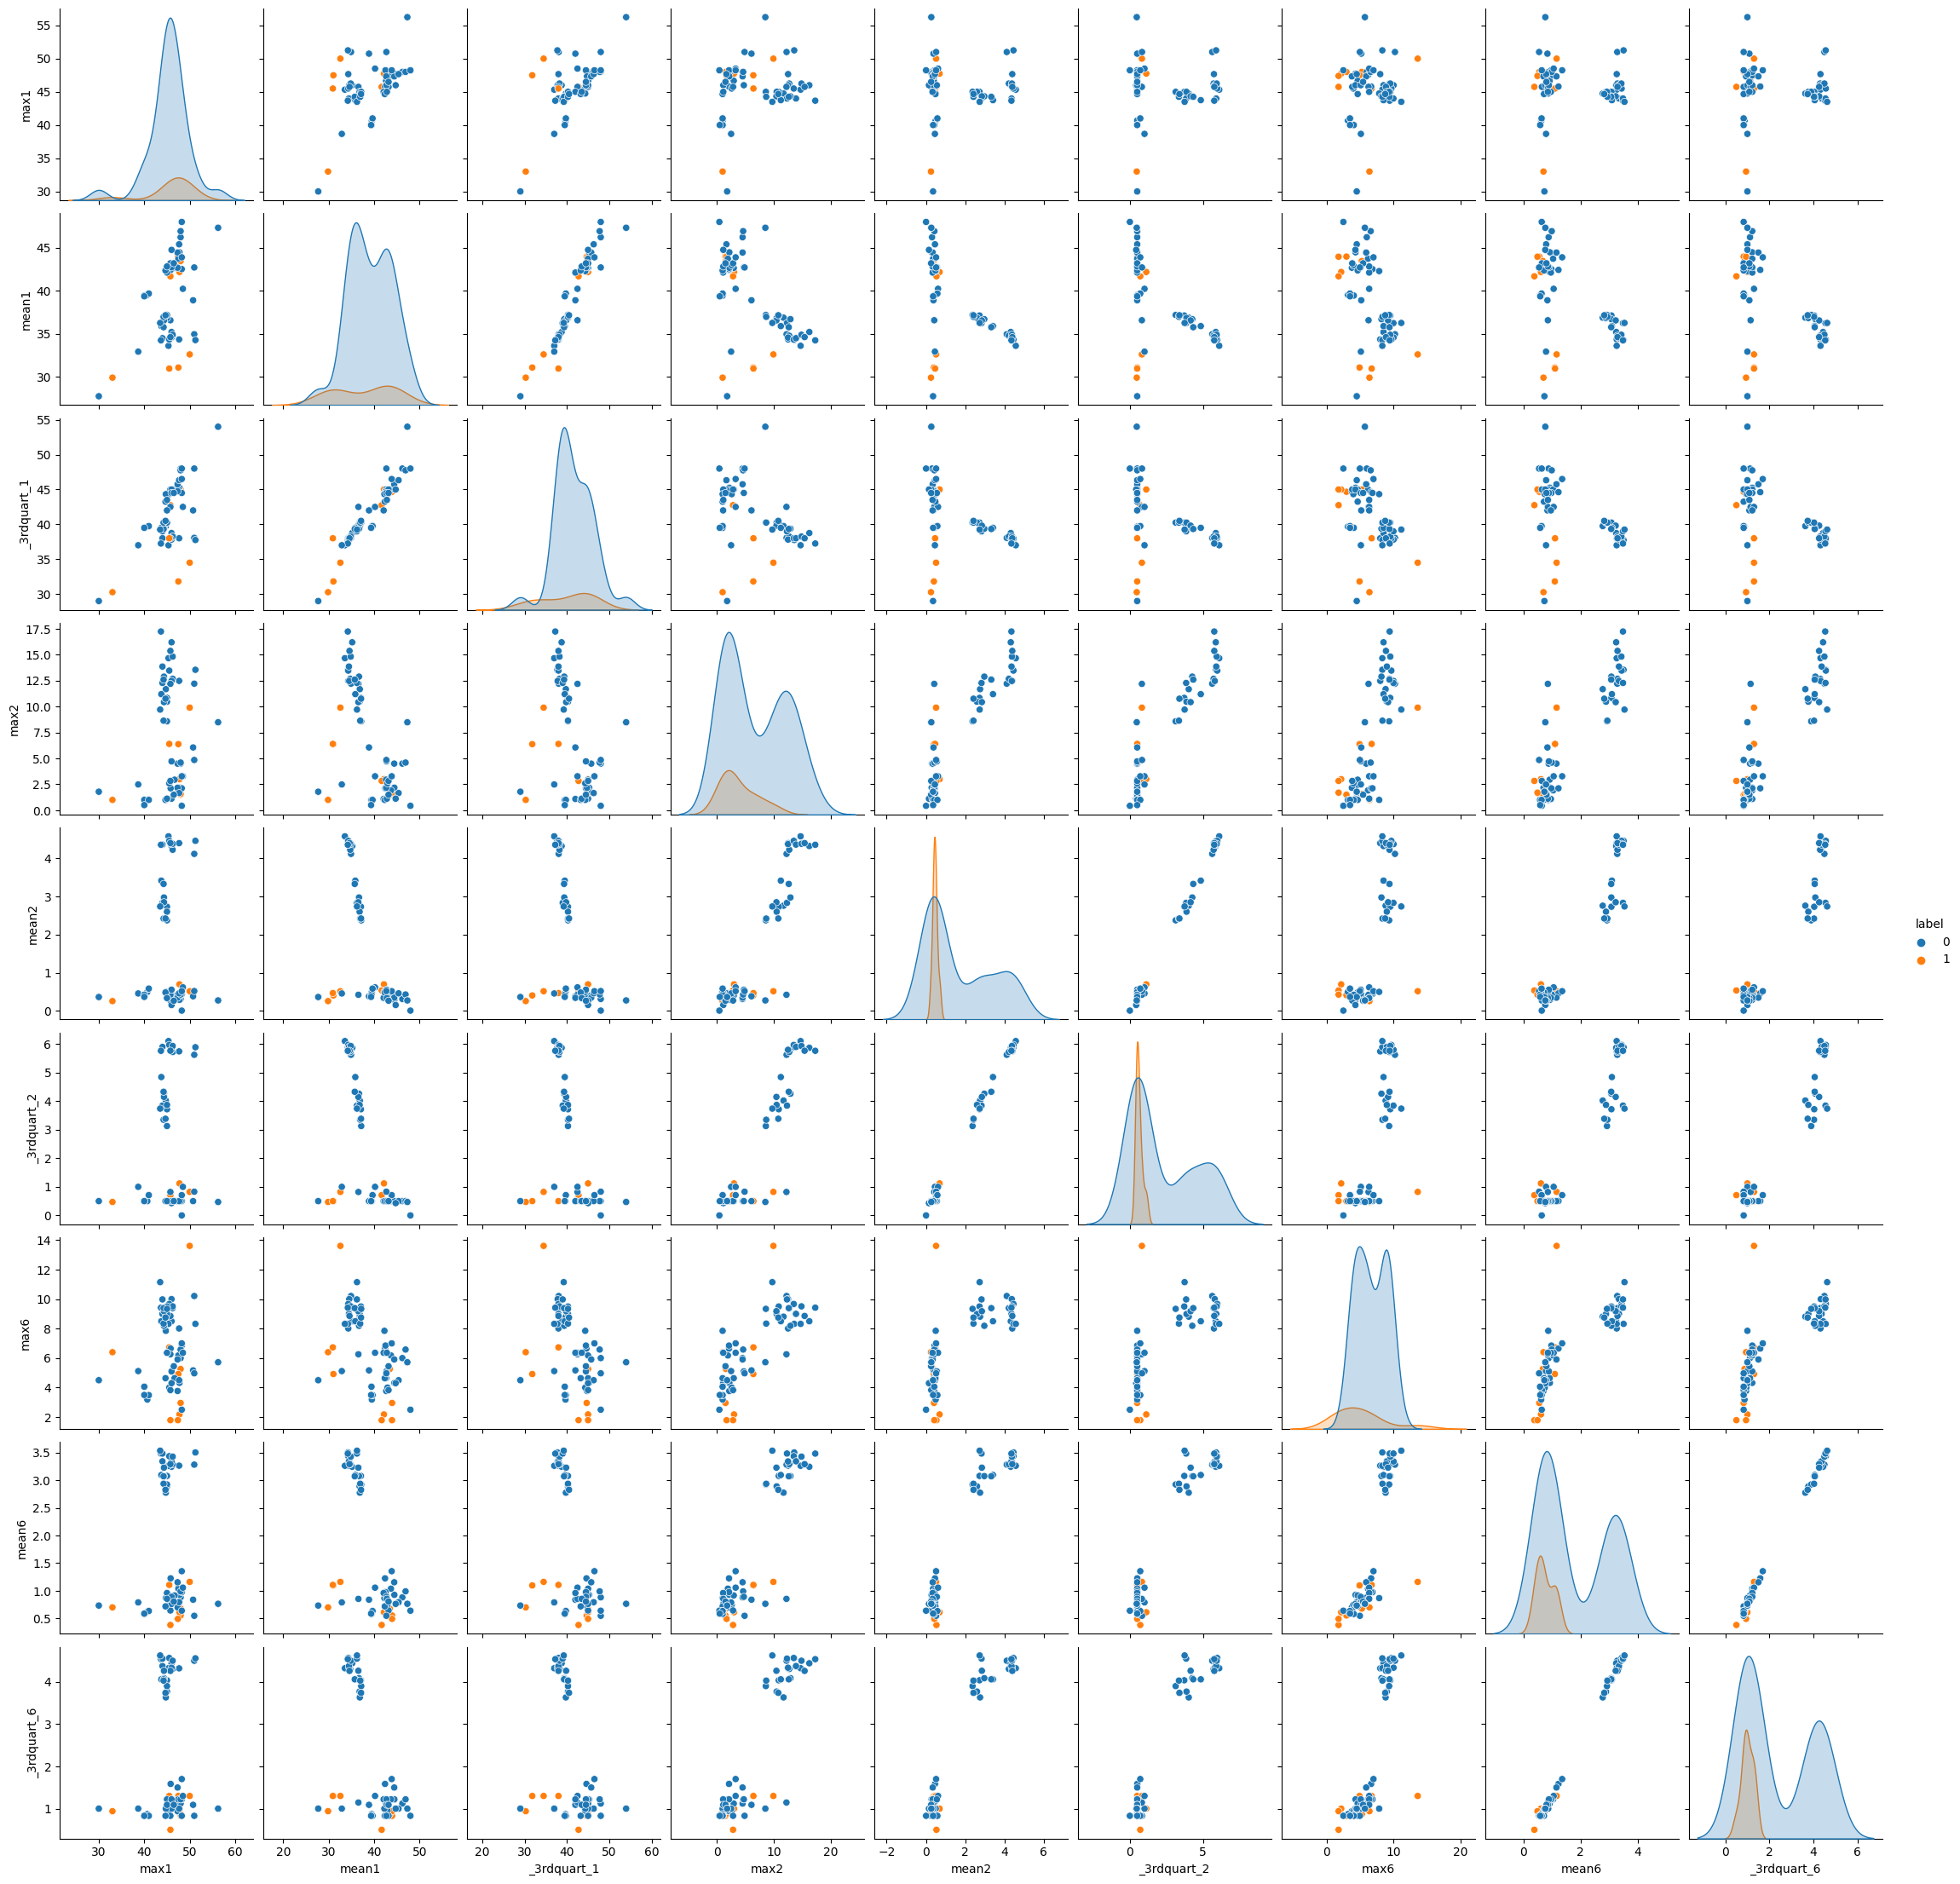

In [16]:
# Select the ['max', 'mean', '_3rdquart_'] of 1, 2 and 6 time series
pairplot(bending_binary_train, [1, 2, 6], ['max', 'mean', '_3rdquart_'])

ii. Break each time series in your training set into two (approximately) equal
 length time series. Now instead of 6 time series for each of the training
 instances, you have 12 time series for each training instance. Repeat the
 experiment in 2(a)i, i.e depict scatter plots of the features extracted from both
 parts of the time series 1,2, and 6. Do you see any considerable diﬀerence in
 the results with those of 2(a)i?

In [17]:
# reorder the columns
statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
# feature = [stat + str(i) for i in range(1, 13) for stat in statistics]

# load dataset as required: break each time series into 2 folds
train_data_2fold = loadData(train_data, statistics, colomns, segs=2)
test_data_2fold = loadData(test_data, statistics, colomns, segs=2)
train_data_2fold

/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/2136608593.py:6: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_data_2fold = loadData(train_data, statistics, colomns, segs=2)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/2136608593.py:6: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_data_2fold = loadData(train_data, statistics, colomns, segs=2)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/2136608593.py:7: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_data_2fold = loadData(test_data, statistics, colomns, segs=2)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/2136608593.py:7: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_data_2fold = loadData(test_data,

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_11,_3rdquart_11,min12,max12,mean12,median12,std12,_1stquart_12,_3rdquart_12,label
0,36.67,45.00,43.486208,43.71,1.281976,42.3300,44.50,0.0,1.30,0.378667,...,21.000,23.5000,0.0,2.96,0.585750,0.50,0.487918,0.4225,0.8300,bending1
1,39.00,48.00,44.117042,45.00,1.359836,43.5000,45.00,0.0,1.30,0.250042,...,22.500,23.7500,0.0,4.06,0.543875,0.50,0.473445,0.4300,0.7100,bending1
2,33.75,47.75,43.278875,45.00,3.473355,42.0000,45.25,0.0,3.00,0.673292,...,28.750,33.7500,0.0,2.18,0.586083,0.47,0.491873,0.0000,0.8700,bending1
3,33.00,45.75,41.621208,42.33,3.118644,39.6525,44.25,0.0,2.83,0.623083,...,28.310,30.5625,0.0,1.50,0.347500,0.43,0.363144,0.0000,0.5000,bending1
4,36.50,46.50,44.057167,44.50,1.556971,43.2500,45.00,0.0,1.50,0.381042,...,33.000,36.2500,0.0,1.50,0.388333,0.00,0.478528,0.0000,0.7100,bending1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,20.00,44.25,35.692167,35.50,4.643595,33.0000,39.25,0.0,11.39,3.324208,...,14.000,18.2500,0.0,8.81,2.966917,2.59,1.712062,1.8525,3.7400,cycling
65,24.25,45.00,36.954208,36.00,3.772836,34.2500,40.25,0.0,8.18,2.392667,...,18.000,21.6700,0.0,9.34,2.838083,2.45,1.890755,1.3825,3.8325,cycling
66,27.00,42.67,36.337908,36.75,3.655379,33.6700,39.00,0.0,9.71,2.698494,...,16.125,21.0000,0.0,11.15,3.530669,3.08,1.998170,2.1700,4.5150,cycling
67,26.25,43.40,36.865417,36.25,3.462793,34.3100,40.00,0.0,7.46,2.387250,...,14.330,18.0000,0.0,8.34,2.904458,2.57,1.609793,1.6900,3.7700,cycling


In [18]:
bending_binary_train_2fold = pd.DataFrame(train_data_2fold)
bending_binary_train_2fold.loc[bending_binary_train_2fold['label'].isin(['bending1', 'bending2']), 'label'] = 1
bending_binary_train_2fold.loc[bending_binary_train_2fold['label'] != 1, 'label'] = 0
#bending_binary_train.loc[bending_binary_train['label'] == 0, '_1stquart_2']
bending_binary_train_2fold

,min1,max1,mean1,median1,std1,_1stquart_1,_3rdquart_1,min2,max2,mean2,...,_1stquart_11,_3rdquart_11,min12,max12,mean12,median12,std12,_1stquart_12,_3rdquart_12,label
0,36.67,45.00,43.486208,43.71,1.281976,42.3300,44.50,0.0,1.30,0.378667,...,21.000,23.5000,0.0,2.96,0.585750,0.50,0.487918,0.4225,0.8300,1
1,39.00,48.00,44.117042,45.00,1.359836,43.5000,45.00,0.0,1.30,0.250042,...,22.500,23.7500,0.0,4.06,0.543875,0.50,0.473445,0.4300,0.7100,1
2,33.75,47.75,43.278875,45.00,3.473355,42.0000,45.25,0.0,3.00,0.673292,...,28.750,33.7500,0.0,2.18,0.586083,0.47,0.491873,0.0000,0.8700,1
3,33.00,45.75,41.621208,42.33,3.118644,39.6525,44.25,0.0,2.83,0.623083,...,28.310,30.5625,0.0,1.50,0.347500,0.43,0.363144,0.0000,0.5000,1
4,36.50,46.50,44.057167,44.50,1.556971,43.2500,45.00,0.0,1.50,0.381042,...,33.000,36.2500,0.0,1.50,0.388333,0.00,0.478528,0.0000,0.7100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,20.00,44.25,35.692167,35.50,4.643595,33.0000,39.25,0.0,11.39,3.324208,...,14.000,18.2500,0.0,8.81,2.966917,2.59,1.712062,1.8525,3.7400,0
65,24.25,45.00,36.954208,36.00,3.772836,34.2500,40.25,0.0,8.18,2.392667,...,18.000,21.6700,0.0,9.34,2.838083,2.45,1.890755,1.3825,3.8325,0
66,27.00,42.67,36.337908,36.75,3.655379,33.6700,39.00,0.0,9.71,2.698494,...,16.125,21.0000,0.0,11.15,3.530669,3.08,1.998170,2.1700,4.5150,0
67,26.25,43.40,36.865417,36.25,3.462793,34.3100,40.00,0.0,7.46,2.387250,...,14.330,18.0000,0.0,8.34,2.904458,2.57,1.609793,1.6900,3.7700,0


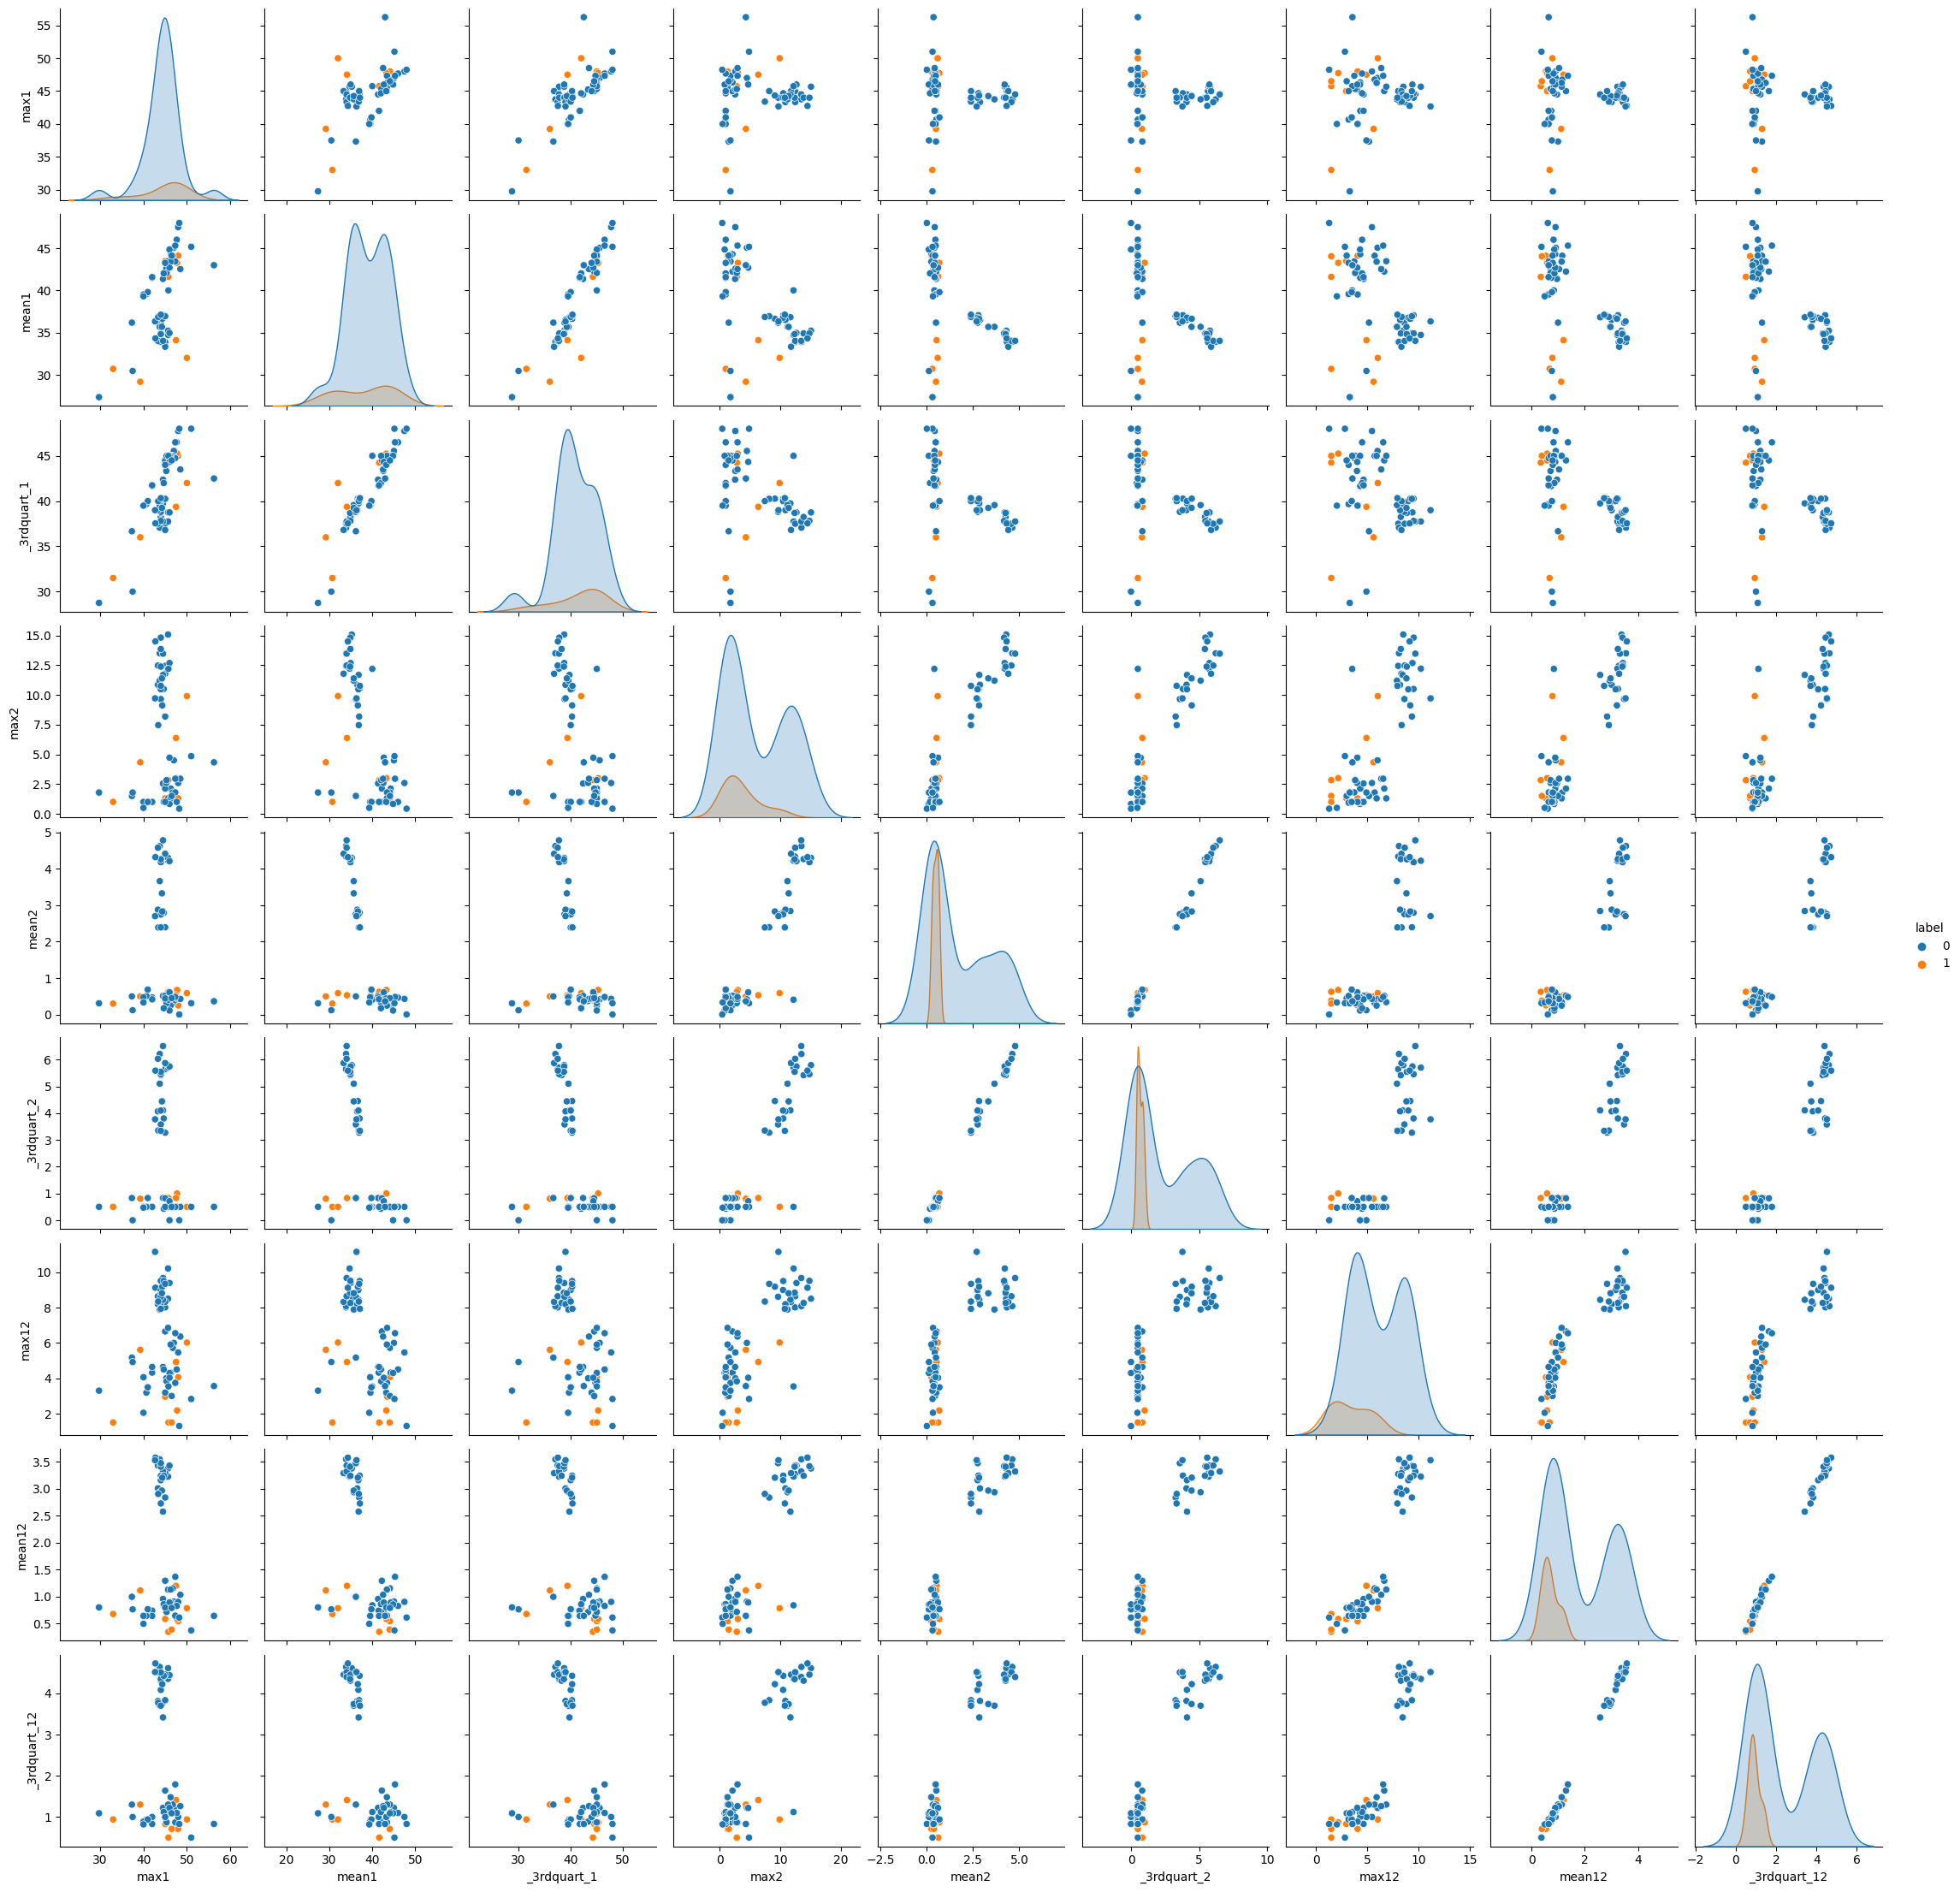

In [19]:
# Select the ['max', 'mean', '_3rdquart_'] of 1, 2 and 12 time series
pairplot(bending_binary_train_2fold, [1, 2, 12], ['max', 'mean', '_3rdquart_'])

iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series
 of approximately equal length and use logistic regression 5to solve the binary
 classiﬁcation problem, using time-domain features. 
 
 Remember that breaking each of the time series does not change the number of instances. It only
 changes the number of features for each instance. 
 
 Calculate the p-values for your logistic regression parameters in each model corresponding to each value of l and reﬁt a logistic regression model using your pruned set of features.6

 Alternatively, you can use backward selection using sklearn.feature selection or glm in R. 
 
 Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination.
 
 Explain what the right way and the wrong way are to perform cross-validation
 in this problem. 7Obviously, use the right way! Also, you may encounter the
 problem of class imbalance, which may make some of your folds not having
 any instances of the rare class. In such a case, you can use stratiﬁed cross
 validation. Research what it means and use it if needed.
 In the following, you can see an example of applying Python’s Recursive

In [20]:
"""
Doc References:

1. StratifiedKFold: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
2. RFECV: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
3. LogisticRegression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba
"""


# import necessary modules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

# perform logistic regression and cross validation for a given value of l
def logisticRegressionCV(train_files, test_files, num_fold, l, penalty, oversample):
    # specify columns
    orig_columns = ['# Columns: time', 
                    'avg_rss12', 'var_rss12', 
                    'avg_rss13', 'var_rss13', 
                    'avg_rss23', 'var_rss23']
    
    statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
    # feature = [stat + str(i) for i in range(1, 6 * l + 1) for stat in statistics]
    
    # load data with given value of l
    train_set = loadData(train_files, statistics, orig_columns, segs=l)
    train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
    train_set.loc[train_set['label'] != "1", 'label'] = "0"
    #print(train_set)
    #test_set = load_data(test_files, feature, orig_columns, segs=l)
    
    # oversample the data if required
    if oversample:
        num_label_0 = train_set.loc[train_set['label'] == "0"].shape[0]
        num_label_1 = train_set.loc[train_set['label'] == "1"].shape[0]
        minor_count = min(num_label_0, num_label_1)
        major_count = max(num_label_0, num_label_1)
        minor_label = "1" if num_label_0 > num_label_1 else "0"
        minor = train_set.loc[train_set['label'] == minor_label]
        major = train_set.loc[train_set['label'] != minor_label]
        minor = resample(minor, replace=True, random_state=60,
                         n_samples=max(num_label_0, num_label_1))
        train_set = pd.concat([major, minor])
        print("Oversample the minority from {} to {} samples".format(minor_count, 
                                                                     major_count))
    
    # split features and labels
    trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
    #print(trainX.shape)
    #testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
    
    # create 5-fold cross validator, logistic regression classifier and featrue selector
    if penalty == 'l1':
        solver = 'liblinear'
    else:
        solver = 'lbfgs'
    validator = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=69)
    model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
    selector = RFECV(estimator=model, cv=validator, scoring='accuracy')
    selector.fit(trainX, trainY)
    
    # return the feature selector
    return model, selector

# interate values of l from 1 to 20
def iterateL(train_files, test_files, num_fold, L, penalty='none', oversample=False):
    best_p = []
    score = []
    
    for l in range(1, L + 1):
        classifier, selector = logisticRegressionCV(train_files, test_files, 
                                                    num_fold, l, penalty=penalty,
                                                    oversample=oversample)
        best_p.append(selector.n_features_)
        score.append(selector.grid_scores_)
        #print(selector.support_)
        print("Pair {}, scores {}".format((l, best_p[-1]), 
                                          round(np.max(selector.grid_scores_), 4)))

In [21]:
iterateL(train_data, test_data, 5, 20)

/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(trai

Pair (1, 6), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (2, 5), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (3, 7), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (4, 9), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (5, 3), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (6, 36), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (7, 16), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (8, 31), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (9, 43), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (10, 47), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (11, 9), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (12, 85), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (13, 12), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (14, 15), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (15, 37), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (16, 12), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (17, 11), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (18, 9), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (19, 10), scores 1.0
Pair (20, 11), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


iv. Report the confusion matrix and show the ROC and AUC for your classiﬁer
 on train data. Report the parameters of your logistic regression β i’s as well
 as the p-values associated with them.

In [22]:
# fit model with l = 1
statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
feature = [stat + str(i) for i in range(1, 6 * 1 + 1) for stat in statistics]

# get the selected feature
classifier, selector = logisticRegressionCV(train_data, test_data, 5, 1, 
                                            penalty='none', oversample=False)
selected_feature = [f for i, f in enumerate(feature) if selector.support_[i]]

selected_feature

/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


['mean1', '_3rdquart_1', 'max2', 'min5', 'max5', '_1stquart_5']

In [23]:
# use statmodels package here to get p-values
import statsmodels.api as sm
import statsmodels.formula.api as smf

train_set = loadData(train_data, statistics, colomns, segs=1)
train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = 1
train_set.loc[train_set['label'] != 1, 'label'] = 0
trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]

# build model, remember to add constant to features
trainX_const = sm.add_constant(trainX.loc[:, selected_feature].to_numpy(dtype=float))
#print(trainY.to_numpy())
model = sm.Logit(trainY.to_numpy(dtype=float), trainX_const)
#logitres = model.fit_regularized()
logitres = model.fit(method='bfgs')

print(logitres.summary())

/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/503886938.py:5: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, colomns, segs=1)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/503886938.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, colomns, segs=1)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Fri, 03 Mar 2023   Pseudo R-squ.:                   1.000
Time:                        10:35:57   Log-Likelihood:            -8.8338e-06
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7796   1.51e+07  -5.1

[[60  0]
 [ 0  9]]


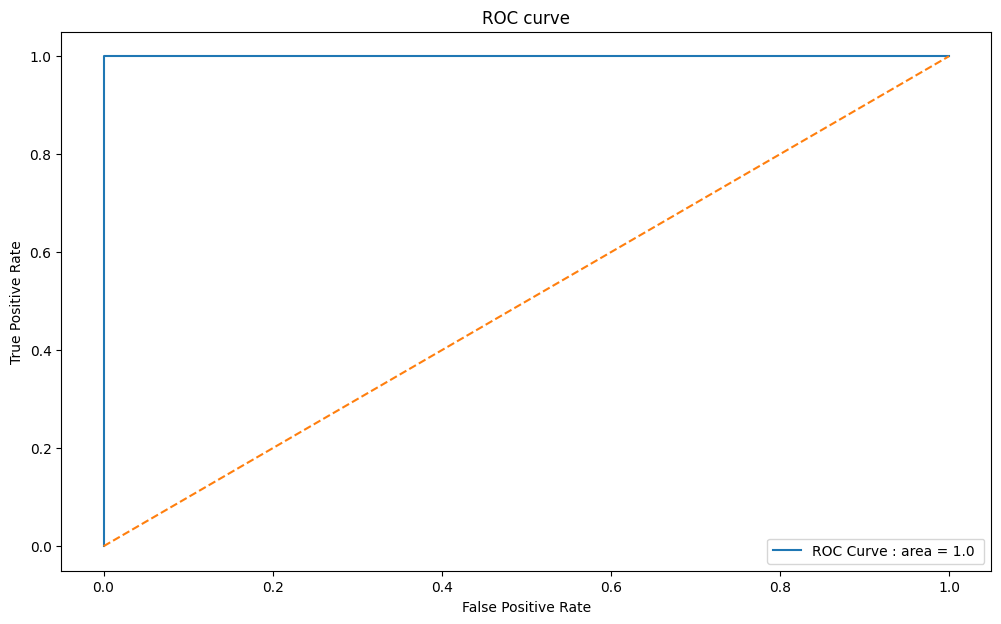

In [24]:
"""
Doc References:
1. confusion_matrix: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
2. roc_curve: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
3. auc: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
"""

from sklearn.metrics import confusion_matrix, roc_curve, auc

# predictY = logitres.predict(trainX_const)
# fpr, tpr, thresholds = roc_curve(trainY.to_numpy(dtype=float), predictY, pos_label=1)
# print(trainY.to_numpy(dtype=float))
# print(type(predictY[0]))

classifier.fit(trainX.loc[:, selected_feature], trainY.to_numpy(dtype="int"))
predictY = classifier.predict(trainX.loc[:, selected_feature])
predictY_prob = classifier.predict_proba(trainX.loc[:, selected_feature])

fpr, tpr, thresholds = roc_curve(trainY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

conf_mat = confusion_matrix(trainY.to_numpy(dtype=float), predictY.round())
print(conf_mat)

fig, axes = plt.subplots(figsize=(12, 7))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve")
plt.show()

v. Test the classiﬁer on the test set. Remember to break the time series in
 your test set into the same number of time series into which you broke your
 training set. Remember that the classiﬁer has to be tested using the features
 extracted from the test set. Compare the accuracy on the test set with the
 cross-validation accuracy you obtained previously.

/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/2518012609.py:1: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, colomns, segs=1)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/2518012609.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, colomns, segs=1)


[[15  0]
 [ 0  4]]


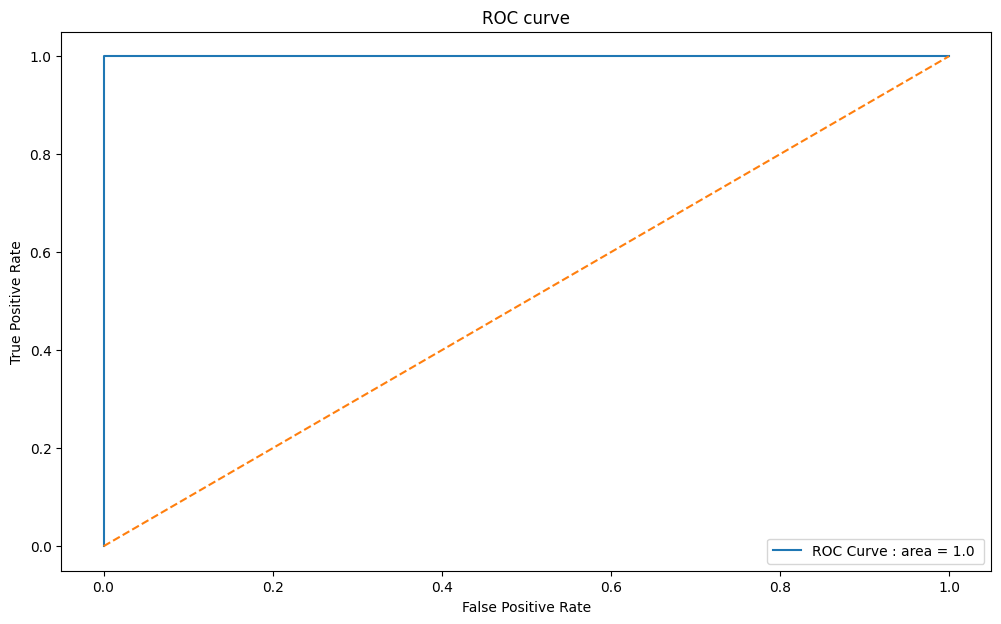

In [27]:
test_set = loadData(test_data, statistics, colomns, segs=1)
test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = 1
test_set.loc[test_set['label'] != 1, 'label'] = 0
testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]

# make predict use the model kept by RFECV
predictY = classifier.predict(testX.loc[:, selected_feature])
predictY_prob = classifier.predict_proba(testX.loc[:, selected_feature])

fpr, tpr, thresholds = roc_curve(testY.to_numpy(dtype="int"), predictY_prob[:, 1], pos_label=1)

# create confusion matrix
conf_mat = confusion_matrix(testY.astype(int), predictY.astype(int))
print(conf_mat)

fig, axes = plt.subplots(figsize=(12, 7))
roc_auc = auc(fpr, tpr)
axes.plot(fpr, tpr, label="ROC Curve : area = {} ".format(roc_auc))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.legend()
axes.set_title("ROC curve")
plt.show()

vi. Do your classes seem to be well-separated to cause instability in calculating
 logistic regression parameters?

Yes

vii. From the confusion matrices you obtained, do you see imbalanced classes?
 If yes, build a logistic regression model based on case-control sampling and
 adjust its parameters. Report the confusion matrix, ROC, and AUC of the
 model.

Yes

In [28]:
iterateL(train_data, test_data, 5, 20, oversample=True)

/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (1, 4), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (2, 7), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (3, 3), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (4, 3), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (5, 3), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (6, 3), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (7, 2), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (8, 3), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (9, 9), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (10, 6), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (11, 2), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (12, 8), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (13, 4), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (14, 7), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (15, 9), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (16, 8), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (17, 4), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (18, 3), scores 1.0
Oversample the minority from 9 to 60 samples


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/9180128.py:27: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_files, statistics, orig_columns, segs=l)


Pair (19, 6), scores 1.0
Oversample the minority from 9 to 60 samples
Pair (20, 7), scores 1.0


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


#### (b) Binary Classiﬁcation Using L 1-penalized logistic regression

i. Repeat 2(a)iii using L 1-penalized logistic regression, 8i.e. instead of using p-
 values for variable selection, use L 1regularization. Note that in this problem,
 you have to cross-validate for both l, the number of time series into which you
 break each of your instances, and λ, the weight of L 1penalty in your logistic
 regression objective function (or C, the budget). Packages usually perform
 cross-validation for λ automatically.9

In [29]:
# function to perform cross validation and find optimal l 
# with given classifier and specified paramter settings
def iterateLWithClf(classifier_obj, kwargs, binary_classes):
    for l in range(1, 20 + 1):
        # specify columns
        orig_columns = ['# Columns: time', 
                        'avg_rss12', 'var_rss12', 
                        'avg_rss13', 'var_rss13', 
                        'avg_rss23', 'var_rss23']
        
        statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
        # feature = [stat + str(i) for i in range(1, 6 * l + 1) for stat in statistics]
        
        # load data with given value of l
        train_set = loadData(train_data, statistics, orig_columns, segs=l)
        test_set = loadData(test_data, statistics, orig_columns, segs=l)
        
        # relabel the instance if it is binary classification
        if binary_classes:
            train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
            train_set.loc[train_set['label'] != "1", 'label'] = "0"
            test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
            test_set.loc[test_set['label'] != "1", 'label'] = "0"
        
        # split feature and label
        trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
        testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
        
        # build the classifier and fit the data
        classifier = classifier_obj(**kwargs)
        classifier.fit(trainX, trainY)
        
        # calculate the scores
        train_score = classifier.score(trainX, trainY)
        test_score = classifier.score(testX, testY)
        
        print("Value of l ~ {} : train scores {}, test score {}".format(l, 
                                                     round(train_score, 4), 
                                                     round(test_score, 4)))

        
# function to plot ROC curves
def plotROC(classifier, groudTruthY, predictY_prob, title):
    fig, axes = plt.subplots(figsize=(12, 7))
    for i, c in enumerate(classifier.classes_):
        fpr, tpr, thresholds = roc_curve(groudTruthY, predictY_prob[:, i], pos_label=c)
        roc_auc = auc(fpr, tpr)
        axes.plot(fpr, tpr, label="ROC Curve of {} : area = {} ".format(c, round(roc_auc, 4)))
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    axes.set_title("ROC curves of {}".format(title))
    plt.show()


def useOptimLonTest(l, classifier, kwargs, binary_classes):
    # specify columns
    orig_columns = ['# Columns: time', 
                    'avg_rss12', 'var_rss12', 
                    'avg_rss13', 'var_rss13', 
                    'avg_rss23', 'var_rss23']
    
    statistics = ['min','max','mean','median','std','_1stquart_', '_3rdquart_']
    # feature = [stat + str(i) for i in range(1, 6 * l + 1) for stat in statistics]
    
    train_set = loadData(train_data, statistics, orig_columns, segs=l)
    test_set = loadData(test_data, statistics, orig_columns, segs=l)
    
    # relabel the instance if it is binary classification
    if binary_classes:
        train_set.loc[train_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
        train_set.loc[train_set['label'] != "1", 'label'] = "0"
        test_set.loc[test_set['label'].isin(['bending1', 'bending2']), 'label'] = "1"
        test_set.loc[test_set['label'] != "1", 'label'] = "0"
    
    trainX, trainY = train_set.iloc[:, :-1], train_set.iloc[:, -1]
    testX, testY = test_set.iloc[:, :-1], test_set.iloc[:, -1]
    
    # the new constructed model
    classifier = classifier(**kwargs)
    classifier.fit(trainX, trainY)
    
    # get prediction probability for both train and test, this is used to get ROC curve
    train_predictY_prob = classifier.predict_proba(trainX)
    predictY_prob = classifier.predict_proba(testX)
    
    # get prediction of test set and its confusion matrix
    predictY = classifier.predict(testX)
    conf_mat = confusion_matrix(testY, predictY)
    print("Confusion matrix on test set:\n{}".format(conf_mat))
    
    # plot ROC for multiple classes
    plotROC(classifier, trainY, train_predictY_prob, "Train Set")
    plotROC(classifier, testY, predictY_prob, "Test Set")

In [30]:
# logistic regression with L1 penalty
from sklearn.linear_model import LogisticRegressionCV

# parameter settings to create model
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'scoring' : 'accuracy',
    'cv' : 5,
    'random_state' : 69,
    'solver' : 'liblinear'
}

iterateLWithClf(LogisticRegressionCV, kwargs, binary_classes=True)

/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 1 : train scores 1.0, test score 1.0


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 2 : train scores 0.9565, test score 0.9474


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 3 : train scores 1.0, test score 1.0


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 4 : train scores 1.0, test score 0.9474


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 5 : train scores 1.0, test score 0.9474


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 6 : train scores 1.0, test score 0.9474


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 7 : train scores 1.0, test score 1.0


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 8 : train scores 1.0, test score 0.9474


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 9 : train scores 1.0, test score 0.9474


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 10 : train scores 1.0, test score 0.9474


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 11 : train scores 1.0, test score 0.9474


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 12 : train scores 1.0, test score 1.0


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 13 : train scores 1.0, test score 1.0


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 14 : train scores 1.0, test score 0.9474


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 15 : train scores 1.0, test score 0.9474


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 16 : train scores 1.0, test score 1.0


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 17 : train scores 1.0, test score 0.9474


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 18 : train scores 1.0, test score 0.9474


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 19 : train scores 1.0, test score 0.9474


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 20 : train scores 1.0, test score 0.9474


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:67: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:67: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:68: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:68: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Confusion matrix on test set:
[[15  0]
 [ 0  4]]


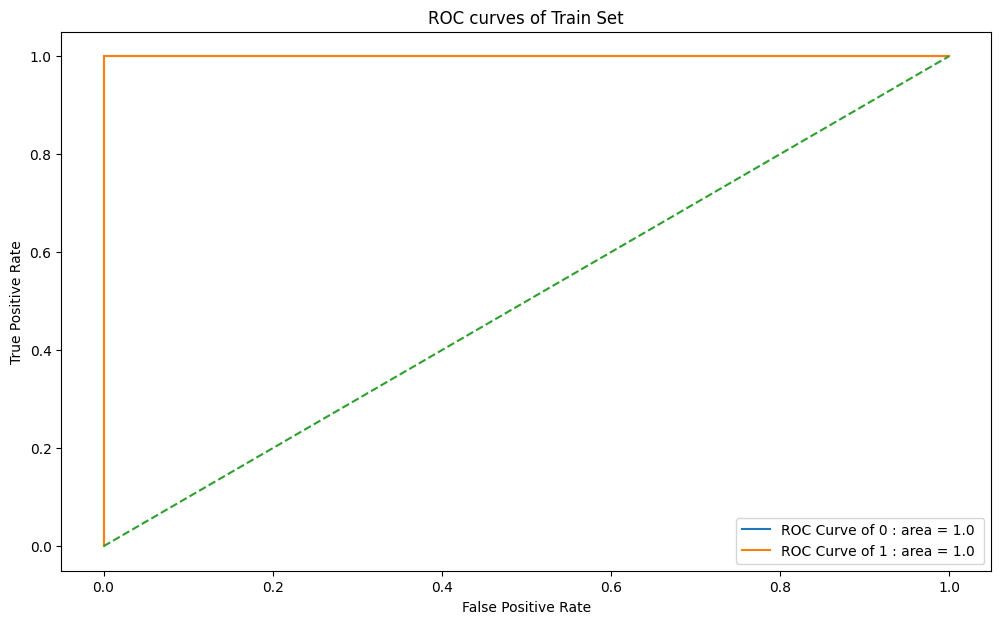

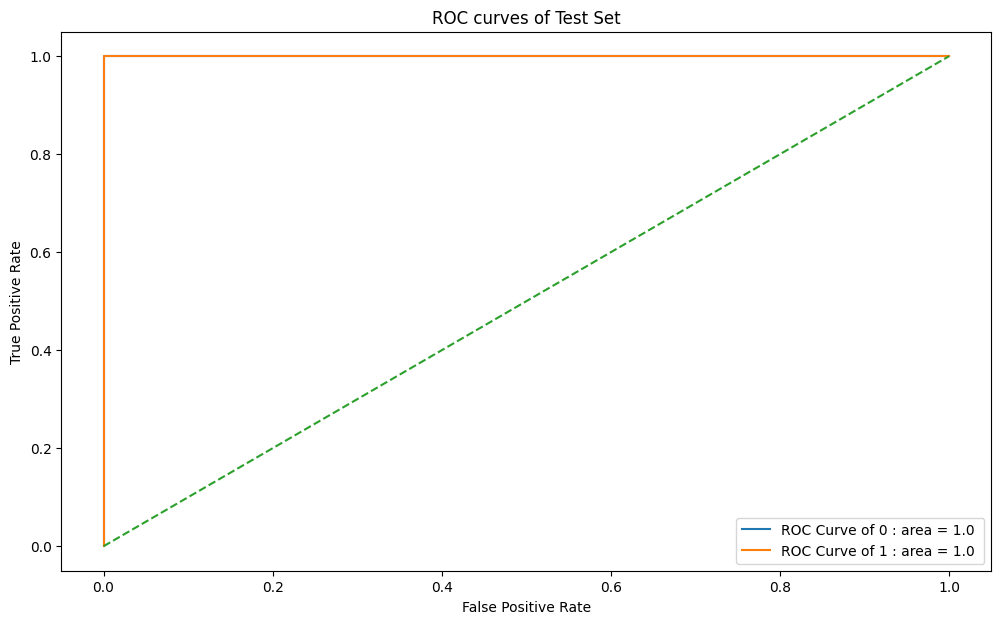

In [31]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'solver' : 'liblinear'
}

useOptimLonTest(1, LogisticRegression, kwargs, binary_classes=True)

ii. Compare the L 1-penalized with variable selection using p-values. Which one
 performs better? Which one is easier to implement?

If We use cross validation score, the L1-penalized is better. The L1-penalized is easier to be used also.Because we do not need to select the features mannually.

#### (c) Multi-class Classiﬁcation (The Realistic Case)
i. Find the best l in the same way as you found it in 2(b)i to build an L 1-
 penalized multinomial regression model to classify all activities in your train-
 ing set. 10Report your test error. Research how confusion matrices and ROC
 curves are deﬁned for multiclass classiﬁcation and show them for this problem
 if possible.11

In [32]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'multi_class' : 'multinomial',
    'cv' : 5,
    'random_state' : 69,
    'solver' : 'saga'
}

iterateLWithClf(LogisticRegressionCV, kwargs, binary_classes=False)

/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 1 : train scores 1.0, test score 0.8947


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 2 : train scores 1.0, test score 0.9474


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 3 : train scores 1.0, test score 0.8421


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 4 : train scores 1.0, test score 0.8947


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 5 : train scores 1.0, test score 0.8421


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 6 : train scores 1.0, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 7 : train scores 1.0, test score 0.7368


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 8 : train scores 1.0, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 9 : train scores 0.9855, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 10 : train scores 1.0, test score 0.8421


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 11 : train scores 1.0, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 12 : train scores 1.0, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 13 : train scores 0.9855, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 14 : train scores 1.0, test score 0.8421


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 15 : train scores 1.0, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 16 : train scores 1.0, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 17 : train scores 0.9855, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 18 : train scores 1.0, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 19 : train scores 1.0, test score 0.8421


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear

Value of l ~ 20 : train scores 1.0, test score 0.7895


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:67: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:67: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:68: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:68: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Confusion matrix on test set:
[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]


/Users/zhangtianzuo/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


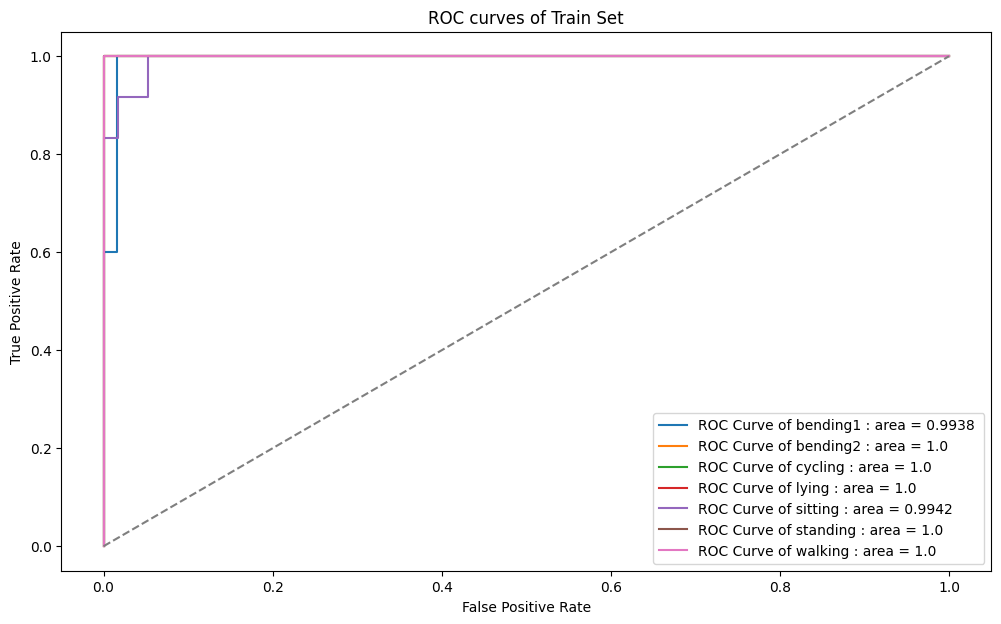

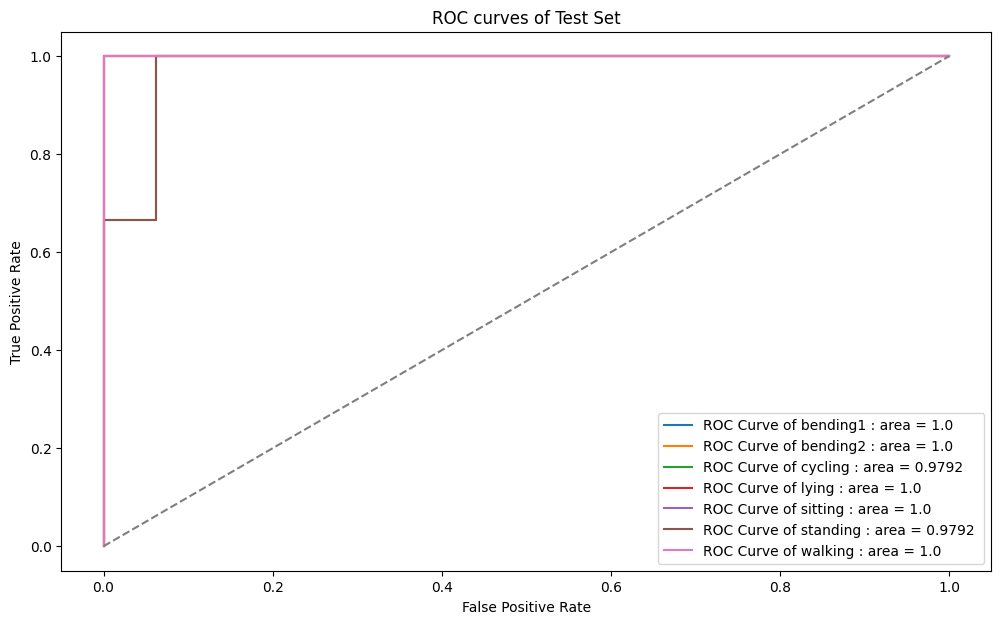

In [33]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'multi_class' : 'multinomial', 
    'solver' : 'saga'
}

useOptimLonTest(2, LogisticRegression, kwargs, binary_classes=False)

ii. Repeat 2(c)i using a Na¨ıve Bayes’ classiﬁer. Use both Gaussian and Multi-
 nomial priors and compare the results.

In [34]:
from sklearn.naive_bayes import GaussianNB

iterateLWithClf(GaussianNB, {}, binary_classes=False)

/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 1 : train scores 1.0, test score 0.8947


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 2 : train scores 1.0, test score 0.6316


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 3 : train scores 0.9855, test score 0.7368


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 4 : train scores 1.0, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 5 : train scores 0.9855, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 6 : train scores 0.971, test score 0.6316


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 7 : train scores 1.0, test score 0.7368


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 8 : train scores 0.9855, test score 0.7368


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 9 : train scores 1.0, test score 0.6842


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 10 : train scores 1.0, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 11 : train scores 0.9855, test score 0.6842


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 12 : train scores 1.0, test score 0.6316


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 13 : train scores 1.0, test score 0.7368


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 14 : train scores 1.0, test score 0.5789


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 15 : train scores 1.0, test score 0.5789


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 16 : train scores 1.0, test score 0.5263


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 17 : train scores 1.0, test score 0.5263


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 18 : train scores 1.0, test score 0.6842


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 19 : train scores 1.0, test score 0.4737


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 20 : train scores 1.0, test score 0.5789


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:67: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:67: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:68: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:68: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Confusion matrix on test set:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]


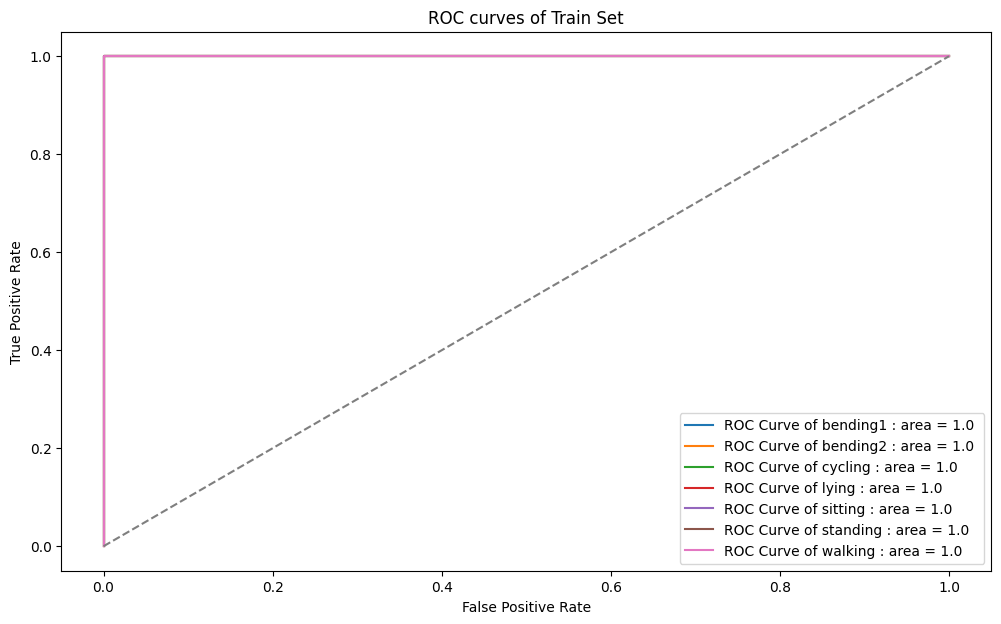

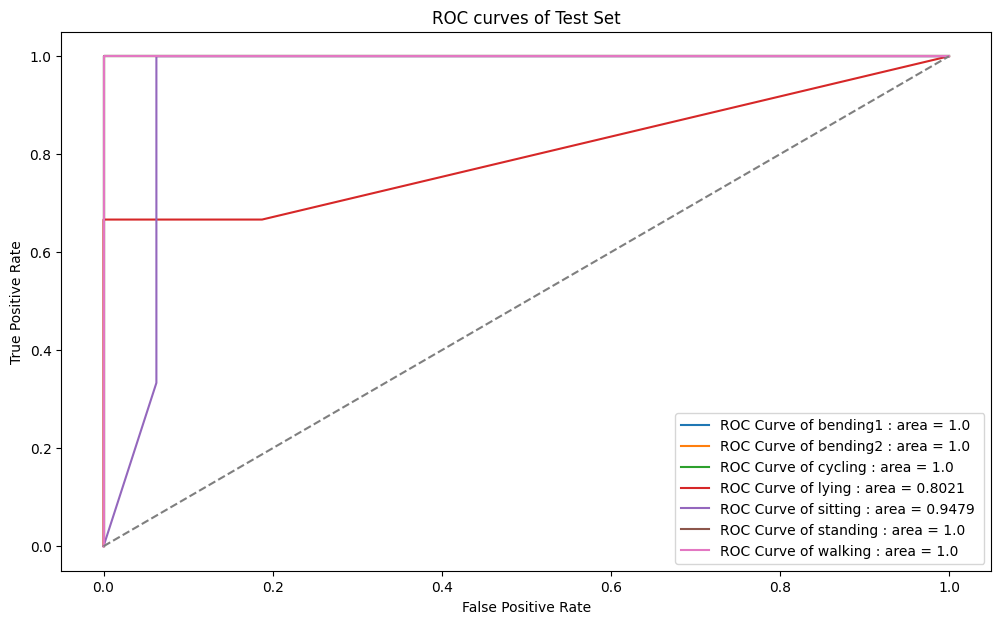

In [35]:
useOptimLonTest(1, GaussianNB, {}, binary_classes=False)

In [36]:
from sklearn.naive_bayes import MultinomialNB

iterateLWithClf(MultinomialNB, {}, binary_classes=False)

/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 1 : train scores 0.9275, test score 0.8947


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 2 : train scores 0.8841, test score 0.7368


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 3 : train scores 0.8986, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 4 : train scores 0.913, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 5 : train scores 0.9275, test score 0.7368


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 6 : train scores 0.9565, test score 0.7368


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 7 : train scores 0.942, test score 0.7368


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 8 : train scores 0.942, test score 0.7368


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 9 : train scores 0.942, test score 0.7368


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 10 : train scores 0.942, test score 0.7368


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 11 : train scores 0.942, test score 0.7368


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 12 : train scores 0.942, test score 0.7368


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 13 : train scores 0.942, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 14 : train scores 0.942, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 15 : train scores 0.942, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 16 : train scores 0.942, test score 0.7895


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 17 : train scores 0.942, test score 0.8421


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 18 : train scores 0.942, test score 0.8421


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 19 : train scores 0.942, test score 0.8421


/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:15: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  train_set = loadData(train_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statistics, orig_columns, segs=l)
/var/folders/wy/wrrw9qpd70lbmbvjhs5nvv280000gn/T/ipykernel_2648/4259980560.py:16: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  test_set = loadData(test_data, statisti

Value of l ~ 20 : train scores 0.942, test score 0.8421


iii. Which method is better for multi-class classiﬁcation in this problem?

The logistic reg has a better ROC, which means logistic reg has a better classification results.